# Genrify Project - Phase II
## Music genre prediction

Henri Toussaint<br>
Victor Saint Guilhem<br>
Benoît Lafon<br>

The project sets out to predict the genre of a music using the Spotify API, which provides audio features for each tracks. To collect the tracks, we used a recommandation function with a genre seed. We handpicked 20 genres in order to best represent tracks, and from each genre, we collected 100 tracks.

In [3]:
from genrify_module import *
%matplotlib inline

### Data Loading Using Pandas

In [7]:
data = pd.read_csv("music_collection.csv")
data = data.iloc[np.random.permutation(len(data))]
pd_attributes = data.loc[:,'acousticness':'valence']
attributes = np.array(pd_attributes)

### Data Shape

In [9]:
print('Number of instances: ' + str(data.shape[0]))
print('Number of attributes: ' + str(pd_attributes.shape[1]))
print('Attributes:')
for i in pd_attributes.columns.values:
    print('\t'+str(i))

Number of instances: 2000
Number of attributes: 13
Attributes:
	acousticness
	danceability
	duration_ms
	energy
	instrumentalness
	key
	liveness
	loudness
	mode
	speechiness
	tempo
	time_signature
	valence


### Performance Measure

## Baselines

### Classification

##### Random prediction

# Target variable

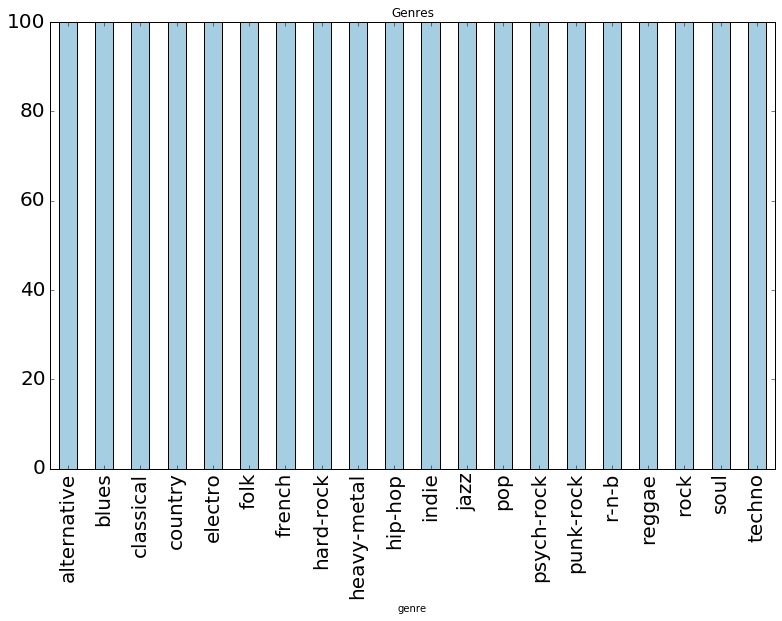

In [7]:
#plt.figure('Genres')
#data['genre'].astype("category")
count_genre = data.groupby("genre").size()
count_genre.plot(kind='bar',title='Genres',figsize=[13,8], colormap='Paired',fontsize=20)


# Target Variable vectorized

In [8]:
pd_target_vect = pd.get_dummies(data['genre'])
pd_target_vect.head()

,alternative,blues,classical,country,electro,folk,french,hard-rock,heavy-metal,hip-hop,indie,jazz,pop,psych-rock,punk-rock,r-n-b,reggae,rock,soul,techno
1359,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1363,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [9]:
target_vect = np.array(pd_target_vect)
print('Dimension: ' + str(target_vect.shape))
print(repr(target_vect))

#Multinomial Target Variable
GENRES = ['alternative','blues','classical','country','electro','folk','french','hard-rock','heavy-metal','hip-hop','indie','jazz','pop','psych-rock','punk-rock','r-n-b','reggae','rock','soul','techno']
target_multinomial = []
for i in data['genre']:
    target_multinomial.append(GENRES.index(i))
target_multinomial=np.array(target_multinomial)

Dimension: (2000, 20)
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)


# Scaled data

In [10]:
sc_attributes = scale(attributes)
#print(repr(sc_attributes))

x_train, x_test, y_train, y_test = train_test_split(sc_attributes, target_multinomial, train_size=0.67, random_state=1)

# Logistic Regression

[0.32650000000000001, 0.34649999999999997, 0.35699999999999998, 0.35649999999999998, 0.35550000000000004, 0.35650000000000004]
['loudness', 'acousticness', 'acousticness', 'loudness', 'danceability', 'acousticness', 'acousticness', 'energy', 'energy', 'danceability', 'acousticness', 'acousticness', 'loudness', 'instrumentalness', 'energy', 'loudness', 'speechiness', 'loudness', 'valence', 'danceability']


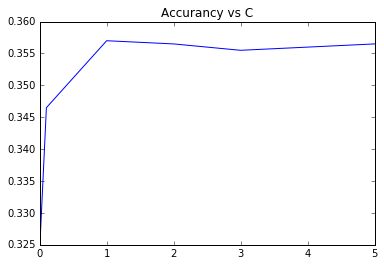

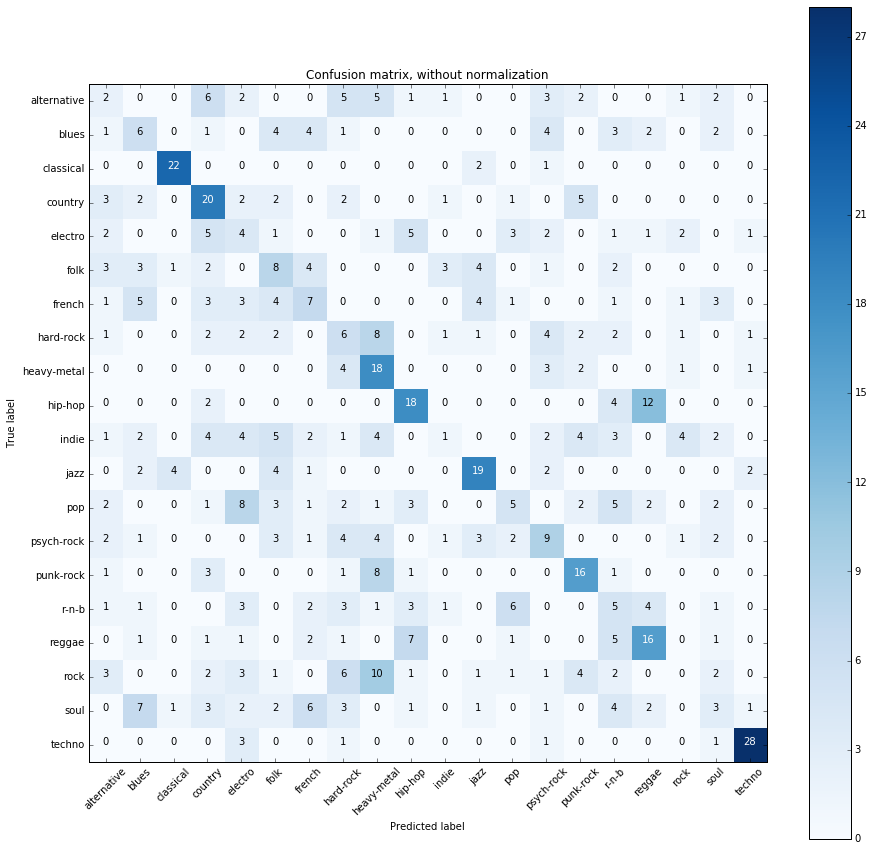

In [11]:
lr_models =[]
Cs = [0.01,0.1,1,2,3,5]
for c in Cs:
    lr_models.append(LogisticRegression(C=c, multi_class='multinomial', solver='newton-cg'))

acc_scores_c=[]
for model in lr_models:
    acc_scores = cross_val_score(model, sc_attributes, target_multinomial,cv=5)
    acc_scores_c.append(np.mean(acc_scores))

plt.plot(Cs,acc_scores_c)
plt.title('Accurancy vs C')
print(acc_scores_c)

lr_fitted = lr_models[4].fit(x_train,y_train) #model for C=3
#print(lr_fitted.coef_)   #array(nb_classes=20, nb_features=13)
indices_max_coef = np.argmax(lr_fitted.coef_, axis=1)
#print(indices_max_coef)
best_attribute_class = []     #Attribute that contributes the most to a given class based on the weight value 
for i in indices_max_coef:
    best_attribute_class.append(pd_attributes.columns.values[i])
print(best_attribute_class)

y_pred_lr = lr_fitted.predict(x_test)

cnf_lr = confusion_matrix(y_test, y_pred_lr)

plot_confusion_matrix(cnf_lr, classes=GENRES,
                      title='Confusion matrix, without normalization')
#plot_confusion_matrix(cnf_lr, classes=GENRES, normalize=True, title='Normalized confusion matrix')

#plot_learning_curve(tree_model, "Decision Tree - LEARNING CURVE", sc_attributes, target_multinomial, cv=5, n_jobs=4)


# Decision Tree

Averaged Decision Tree Accuracy: 0.2785


<module 'matplotlib.pyplot' from '/Users/Victor/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

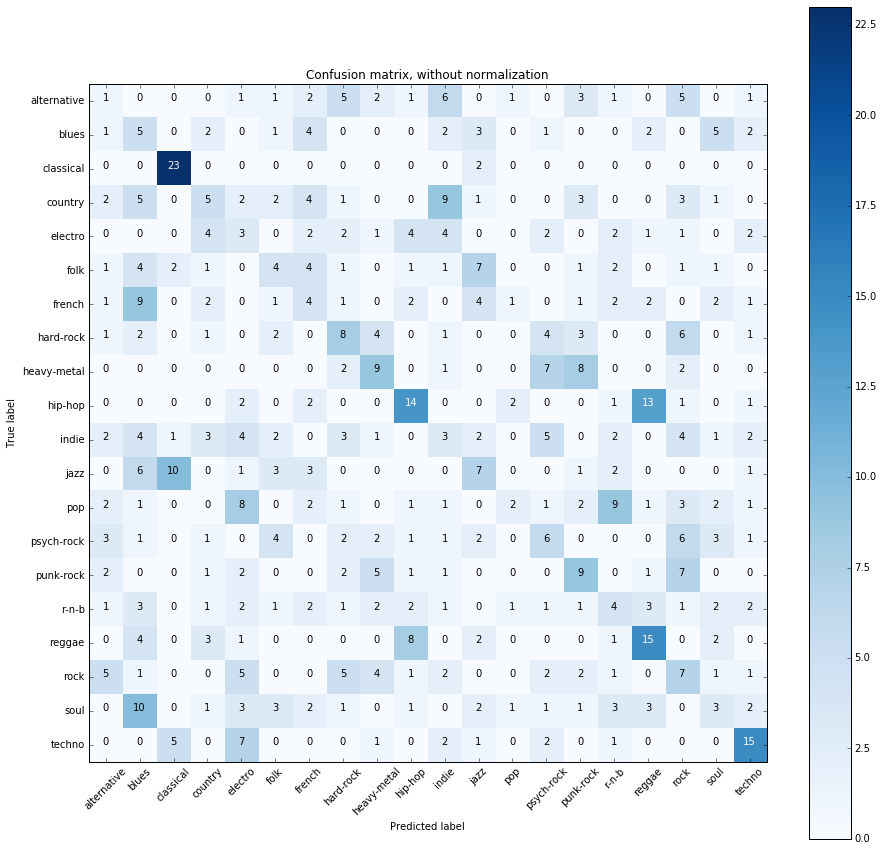

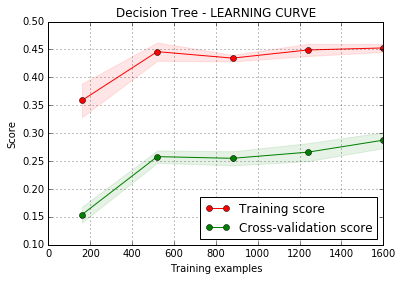

In [12]:
tree_model = tree.DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=15)

tree_acc_scores = cross_val_score(tree_model, sc_attributes, target_multinomial,cv=10)
avg_tree_acc = np.mean(tree_acc_scores)
print("Averaged Decision Tree Accuracy: " + str(avg_tree_acc))

tree_fitted = tree_model.fit(x_train, y_train)

y_pred_tree = tree_fitted.predict(x_test)

cnf_tree = confusion_matrix(y_test, y_pred_tree)

plot_confusion_matrix(cnf_tree, classes=GENRES,
                      title='Confusion matrix, without normalization')

plot_learning_curve(tree_model, "Decision Tree - LEARNING CURVE", sc_attributes, target_multinomial, cv=5, n_jobs=4)


# Naïve Bayes

Averaged Naïve Bayes Accuracy: 0.305


<module 'matplotlib.pyplot' from '/Users/Victor/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

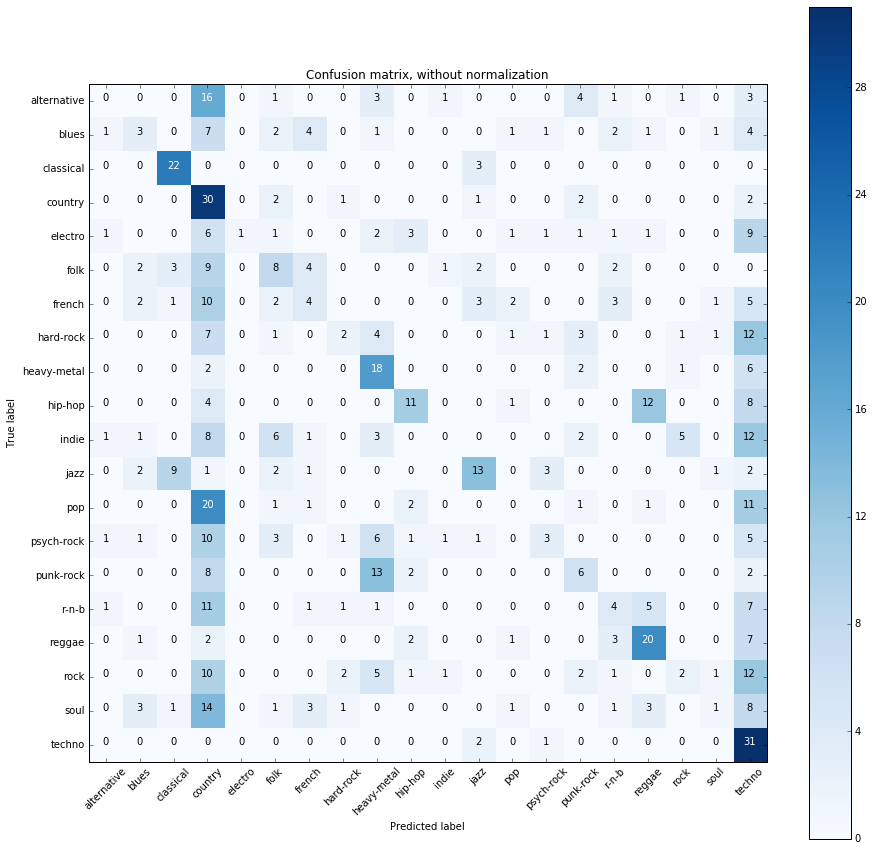

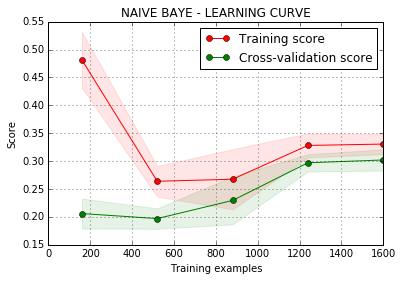

In [ ]:
NB_model = GaussianNB()
NB_acc_scores = cross_val_score(NB_model, sc_attributes, target_multinomial,cv=10)

avg_NB_acc = np.mean(NB_acc_scores)
print("Averaged Naïve Bayes Accuracy: " + str(avg_NB_acc))

NB_fitted = NB_model.fit(x_train, y_train)

y_pred_NB = NB_fitted.predict(x_test)

cnf_NB = confusion_matrix(y_test, y_pred_NB)

plot_confusion_matrix(cnf_NB, classes=GENRES,
                      title='Confusion matrix, without normalization')

#train_sizes, train_scores, valid_scores = learning_curve(
#            GaussianNB(), sc_attributes, target_multinomial, train_sizes=[50, 80, 110], cv=5)
plot_learning_curve(NB_model, "NAIVE BAYE - LEARNING CURVE", sc_attributes, target_multinomial, cv=5, n_jobs=4)



# Neural Networks

In [ ]:
NN_model = MLPClassifier(hidden_layer_sizes=(200,),alpha=10,activation='tanh', solver='lbfgs')
NN_acc_scores = cross_val_score(NN_model, sc_attributes, target_multinomial,cv=10)

avg_NN_acc = np.mean(NN_acc_scores)
print("Averaged Neural Networks Accuracy: " + str(avg_NN_acc))

NN_fitted = NN_model.fit(x_train, y_train)

y_pred_NN = NN_fitted.predict(x_test)

cnf_NN = confusion_matrix(y_test, y_pred_NN)

plot_confusion_matrix(cnf_NN, classes=GENRES,
                      title='Confusion matrix, without normalization')

#train_sizes, train_scores, valid_scores = learning_curve(
#            GaussianNB(), sc_attributes, target_multinomial, train_sizes=[50, 80, 110], cv=5)
plot_learning_curve(NN_model, "Neural Networks - LEARNING CURVE", sc_attributes, target_multinomial, cv=5, n_jobs=4)

Averaged Neural Networks Accuracy: 0.362


# Random Forest

In [ ]:
RF_model = RandomForestClassifier(min_samples_split=5, min_samples_leaf=10)
RF_acc_scores = cross_val_score(RF_model, sc_attributes, target_multinomial,cv=10)

avg_RF_acc = np.mean(NN_acc_scores)
print("Averaged Random Forest Accuracy: " + str(avg_RF_acc))

RF_fitted = RF_model.fit(x_train, y_train)

y_pred_RF = RF_fitted.predict(x_test)

cnf_RF = confusion_matrix(y_test, y_pred_RF)

plot_confusion_matrix(cnf_RF, classes=GENRES,
                      title='Confusion matrix, without normalization')

#train_sizes, train_scores, valid_scores = learning_curve(
#            GaussianNB(), sc_attributes, target_multinomial, train_sizes=[50, 80, 110], cv=5)
plot_learning_curve(NN_model, "Random Forest - LEARNING CURVE", sc_attributes, target_multinomial, cv=5, n_jobs=4)